Kesci competition

### 导入数据

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_data = pd.read_csv('train_set.csv')

#data
test_data = pd.read_csv('test_set.csv')

#test_data
print(train_data.dtypes)

ID            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object


查看数据的指标

In [2]:
train_data.describe()

,ID,age,balance,day,duration,campaign,pdays,previous,y
count,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000
mean,12659.000000,40.935379,1357.555082,15.835289,257.732393,2.772050,40.248766,0.591737,0.116957
std,7308.532719,10.634289,2999.822811,8.319480,256.975151,3.136097,100.213541,2.568313,0.321375
min,1.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6330.000000,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,12659.000000,39.000000,448.000000,16.000000,181.000000,2.000000,-1.000000,0.000000,0.000000
75%,18988.000000,48.000000,1435.000000,21.000000,317.000000,3.000000,-1.000000,0.000000,0.000000
max,25317.000000,95.000000,102127.000000,31.000000,3881.000000,55.000000,854.000000,275.000000,1.000000


特征选择

0 features with greater than 0.60 missing values.

0 features with a single unique value.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[171]	valid_0's auc: 0.934434	valid_0's binary_logloss: 0.199828
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[199]	valid_0's auc: 0.937349	valid_0's binary_logloss: 0.198191
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[124]	valid_0's auc: 0.937208	valid_0's binary_logloss: 0.190061
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	valid_0's auc: 0.932754	valid_0's binary_logloss: 0.195473
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	valid_0's auc: 0.936002	valid_0's binary_logloss: 0.197509
Training until validation scores don't improve for 100 round

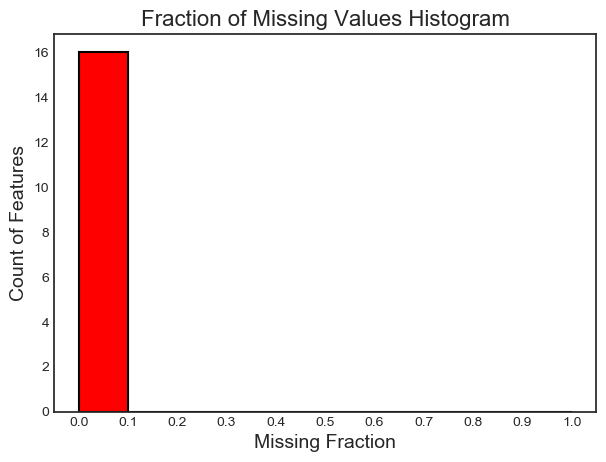

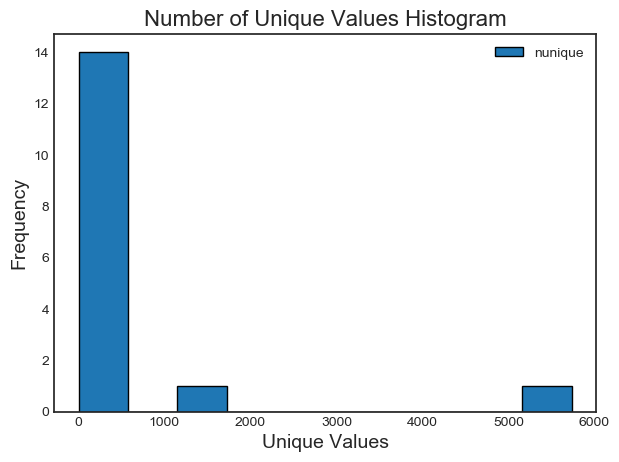

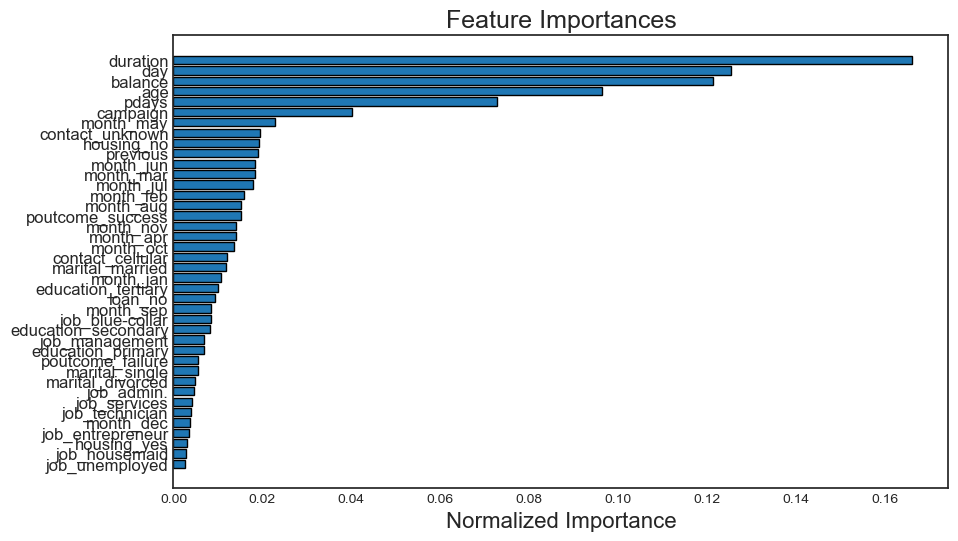

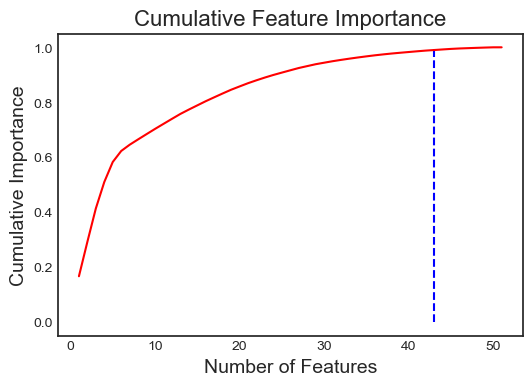

43 features required for 0.99 of cumulative importance


In [3]:
from feature_selector import FeatureSelector

# missing
fs = FeatureSelector(data = train_data.drop(['ID','y'], axis=1), labels = train_data['y'])

fs.identify_missing(missing_threshold=0.6)

missing_features = fs.ops['missing']
missing_features[:10]

fs.plot_missing()

# single unique
fs.identify_single_unique()

single_unique = fs.ops['single_unique']
single_unique

fs.plot_unique()

# Collinear (highly correlated) Features
# fs.identify_collinear(correlation_threshold=0.9)

# correlated_features = fs.ops['collinear']
# correlated_features[:5]

# fs.plot_collinear()
# fs.plot_collinear(plot_all=True)

#  important feature
fs.identify_zero_importance(task = 'classification', 
 eval_metric = 'auc', 
 n_iterations = 10, 
 early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

fs.plot_feature_importances(threshold = 0.99, plot_n = 40)

# ['duration', 'balance', 'day', 'age', 'pdays', 'campaign']

数据预处理

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

for col in train_data.columns[train_data.dtypes == 'object']:
    label_encoder = LabelEncoder()
    label_encoder.fit(train_data[col])

    train_data[col] = label_encoder.transform(train_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

scaler.fit(train_data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']])

train_data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']]=scaler.transform(train_data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']])
test_data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']]=scaler.transform(test_data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']])

# train_data.head(100)
# test_data.head(100)

C:\Users\Matthew\AppData\Local\conda\conda\envs\kesci36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Matthew\AppData\Local\conda\conda\envs\kesci36\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\Matthew\AppData\Local\conda\conda\envs\kesci36\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [5]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2



分割训练集和验证集

In [6]:
from sklearn.model_selection import train_test_split

prediction = train_data['y']

train_use_col = list(set(train_data.columns) - set(['ID', 'y']))

features = train_data[train_use_col]

# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(train_data[train_use_col],train_data['y'])

# bestfeatures.transform(test_data[train_use_col])

X_train, X_test, y_train, y_test = train_test_split(features, prediction, test_size=0.2, random_state=55)

print(features)

print("Training and testing split was successful.")

       marital     pdays  month       age  job  default  campaign  poutcome  \
0            1 -0.411617      8  0.194151    4        0 -0.246187         3   
1            0  2.103063      0  0.100114    9        0 -0.565061         1   
2            1 -0.411617      5  0.570301    0        0 -0.246187         3   
3            2 -0.411617      5 -1.216408    4        0 -0.246187         3   
4            0 -0.411617      8  0.100114    9        0  0.710435         3   
5            0 -0.411617      6  1.416636    7        0 -0.565061         3   
6            2 -0.411617      9 -0.840259    4        0  0.391561         3   
7            2 -0.411617      1 -0.746222    4        0 -0.246187         3   
8            2 -0.411617      1 -0.840259    9        0  0.072687         3   
9            1 -0.411617      6  1.322599    4        0  0.072687         3   
10           1 -0.411617      4  1.228562    9        0 -0.565061         3   
11           1  1.983316      0  1.698748    5      

使用lgb进行训练

In [7]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': {'auc'},
#     'num_leaves': 5,
#     'max_depth': 6,
#     'min_data_in_leaf': 450,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.95,
#     'bagging_freq': 5,
#     'lambda_l1': 1,
#     'lambda_l2': 0.001,
#     'min_gain_to_split': 0.2,
#     'verbose': 5,
#     'is_unbalance': True
# }

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    # 'max_bin': 255,
    # 'num_leaves': 30,
    # 'max_depth': 5,
    # 'min_data_in_leaf': 450,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.90,
    'bagging_freq': 15,
    'lambda_l1': 2,
    'lambda_l2': 0.001,
    # 'min_gain_to_split': 0.2,
    # 'num_iterations': 100,
    'verbose': 0,
    'is_unbalance': True,
    # 'num_leaves' : 50,
    # 'num_trees' : 1000,
    # 'num_threads' : 32,
    # 'min_data_in_leaf' : 0,
    # 'min_sum_hessian_in_leaf' : 15
}

# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=1000,
#                 valid_sets=lgb_eval,
#                 valid_names=None,
#                 fobj=None, feval=None, init_model=None,
#                 feature_name='auto', categorical_feature=['job', 'marital','education','default','housing','loan','contact','poutcome'],
#                 early_stopping_rounds=10, evals_result=None,
#                 verbose_eval=True,
#                 keep_training_booster=False, callbacks=None)

model = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                feature_name='auto',
                # categorical_feature=['month','campaign','job', 'marital','education','default','contact','housing','contact','poutcome'],
                # categorical_feature=['campaign', 'job', 'marital', 'education', 'default', 'contact','housing', 'contact', 'poutcome'],
                # categorical_feature=['month','campaign','job', 'marital','education','contact','contact','poutcome'],
                # categorical_feature=['month','campaign','job', 'balance', 'marital','education','contact','contact','poutcome'],
                # categorical_feature = 'auto',
                # categorical_feature=['duration','day','balance', 'balance', 'month','age','pdays','job','campaign', 'education'],
                categorical_feature = ['month','contact','housing','poutcome'],
                early_stopping_rounds=1000
                )

preds = model.predict(test_data[train_use_col], num_iteration=model.best_iteration)

test_data['pred'] = preds

C:\Users\Matthew\AppData\Local\conda\conda\envs\kesci36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contact', 'housing', 'month', 'poutcome']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\Matthew\AppData\Local\conda\conda\envs\kesci36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contact', 'housing', 'month', 'poutcome']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.893051
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's auc: 0.897976
[3]	valid_0's auc: 0.901716
[4]	valid_0's auc: 0.905169
[5]	valid_0's auc: 0.905316
[6]	valid_0's auc: 0.904828
[7]	valid_0's auc: 0.905472
[8]	valid_0's auc: 0.905661
[9]	valid_0's auc: 0.907936
[10]	valid_0's auc: 0.909475
[11]	valid_0's auc: 0.910903
[12]	valid_0's auc: 0.911387
[13]	valid_0's auc: 0.915075
[14]	valid_0's auc: 0.915637
[15]	valid_0's auc: 0.915699
[16]	valid_0's auc: 0.916114
[17]	valid_0's auc: 0.916226
[18]	valid_0's auc: 0.916579
[19]	valid_0's auc: 0.917082

C:\Users\Matthew\AppData\Local\conda\conda\envs\kesci36\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')



[20]	valid_0's auc: 0.917045
[21]	valid_0's auc: 0.917069
[22]	valid_0's auc: 0.917399
[23]	valid_0's auc: 0.917698
[24]	valid_0's auc: 0.918206
[25]	valid_0's auc: 0.918931
[26]	valid_0's auc: 0.918943
[27]	valid_0's auc: 0.919145
[28]	valid_0's auc: 0.919558
[29]	valid_0's auc: 0.919575
[30]	valid_0's auc: 0.919722
[31]	valid_0's auc: 0.919984
[32]	valid_0's auc: 0.920367
[33]	valid_0's auc: 0.92053
[34]	valid_0's auc: 0.920818
[35]	valid_0's auc: 0.921134
[36]	valid_0's auc: 0.921233
[37]	valid_0's auc: 0.921239
[38]	valid_0's auc: 0.921517
[39]	valid_0's auc: 0.921955
[40]	valid_0's auc: 0.922169
[41]	valid_0's auc: 0.922486
[42]	valid_0's auc: 0.922772
[43]	valid_0's auc: 0.923096
[44]	valid_0's auc: 0.923297
[45]	valid_0's auc: 0.923698
[46]	valid_0's auc: 0.923936
[47]	valid_0's auc: 0.924061
[48]	valid_0's auc: 0.924202
[49]	valid_0's auc: 0.924242
[50]	valid_0's auc: 0.924377
[51]	valid_0's auc: 0.924652
[52]	valid_0's auc: 0.924712
[53]	valid_0's auc: 0.924961
[54]	valid_0's

[312]	valid_0's auc: 0.937056
[313]	valid_0's auc: 0.93711
[314]	valid_0's auc: 0.937142
[315]	valid_0's auc: 0.93715
[316]	valid_0's auc: 0.937136
[317]	valid_0's auc: 0.937223
[318]	valid_0's auc: 0.937332
[319]	valid_0's auc: 0.937424
[320]	valid_0's auc: 0.937461
[321]	valid_0's auc: 0.937474
[322]	valid_0's auc: 0.937473
[323]	valid_0's auc: 0.937486
[324]	valid_0's auc: 0.937531
[325]	valid_0's auc: 0.937562
[326]	valid_0's auc: 0.93764
[327]	valid_0's auc: 0.937741
[328]	valid_0's auc: 0.937788
[329]	valid_0's auc: 0.937823
[330]	valid_0's auc: 0.937788
[331]	valid_0's auc: 0.937781
[332]	valid_0's auc: 0.937812
[333]	valid_0's auc: 0.93782
[334]	valid_0's auc: 0.937815
[335]	valid_0's auc: 0.937807
[336]	valid_0's auc: 0.937821
[337]	valid_0's auc: 0.937853
[338]	valid_0's auc: 0.937861
[339]	valid_0's auc: 0.937824
[340]	valid_0's auc: 0.937844
[341]	valid_0's auc: 0.937824
[342]	valid_0's auc: 0.937813
[343]	valid_0's auc: 0.937776
[344]	valid_0's auc: 0.937805
[345]	valid_0'

[596]	valid_0's auc: 0.939267
[597]	valid_0's auc: 0.939217
[598]	valid_0's auc: 0.939183
[599]	valid_0's auc: 0.93915
[600]	valid_0's auc: 0.939157
[601]	valid_0's auc: 0.939166
[602]	valid_0's auc: 0.939164
[603]	valid_0's auc: 0.939141
[604]	valid_0's auc: 0.939127
[605]	valid_0's auc: 0.939129
[606]	valid_0's auc: 0.939107
[607]	valid_0's auc: 0.939111
[608]	valid_0's auc: 0.939124
[609]	valid_0's auc: 0.939085
[610]	valid_0's auc: 0.939087
[611]	valid_0's auc: 0.939088
[612]	valid_0's auc: 0.93908
[613]	valid_0's auc: 0.939066
[614]	valid_0's auc: 0.939064
[615]	valid_0's auc: 0.939071
[616]	valid_0's auc: 0.939094
[617]	valid_0's auc: 0.939066
[618]	valid_0's auc: 0.939077
[619]	valid_0's auc: 0.939073
[620]	valid_0's auc: 0.939092
[621]	valid_0's auc: 0.93912
[622]	valid_0's auc: 0.939132
[623]	valid_0's auc: 0.939153
[624]	valid_0's auc: 0.939166
[625]	valid_0's auc: 0.939168
[626]	valid_0's auc: 0.939188
[627]	valid_0's auc: 0.939193
[628]	valid_0's auc: 0.939196
[629]	valid_0

[872]	valid_0's auc: 0.939035
[873]	valid_0's auc: 0.939025
[874]	valid_0's auc: 0.93901
[875]	valid_0's auc: 0.939019
[876]	valid_0's auc: 0.93902
[877]	valid_0's auc: 0.939041
[878]	valid_0's auc: 0.939038
[879]	valid_0's auc: 0.939057
[880]	valid_0's auc: 0.939065
[881]	valid_0's auc: 0.939041
[882]	valid_0's auc: 0.939065
[883]	valid_0's auc: 0.939074
[884]	valid_0's auc: 0.939055
[885]	valid_0's auc: 0.939053
[886]	valid_0's auc: 0.939083
[887]	valid_0's auc: 0.939117
[888]	valid_0's auc: 0.939141
[889]	valid_0's auc: 0.939153
[890]	valid_0's auc: 0.93917
[891]	valid_0's auc: 0.939188
[892]	valid_0's auc: 0.939203
[893]	valid_0's auc: 0.939207
[894]	valid_0's auc: 0.939215
[895]	valid_0's auc: 0.939222
[896]	valid_0's auc: 0.939249
[897]	valid_0's auc: 0.939246
[898]	valid_0's auc: 0.939283
[899]	valid_0's auc: 0.939303
[900]	valid_0's auc: 0.939322
[901]	valid_0's auc: 0.939299
[902]	valid_0's auc: 0.939296
[903]	valid_0's auc: 0.939275
[904]	valid_0's auc: 0.939214
[905]	valid_0

[1145]	valid_0's auc: 0.938958
[1146]	valid_0's auc: 0.938938
[1147]	valid_0's auc: 0.93892
[1148]	valid_0's auc: 0.938901
[1149]	valid_0's auc: 0.938894
[1150]	valid_0's auc: 0.938889
[1151]	valid_0's auc: 0.938866
[1152]	valid_0's auc: 0.938876
[1153]	valid_0's auc: 0.938873
[1154]	valid_0's auc: 0.938879
[1155]	valid_0's auc: 0.938887
[1156]	valid_0's auc: 0.938876
[1157]	valid_0's auc: 0.93888
[1158]	valid_0's auc: 0.938859
[1159]	valid_0's auc: 0.938876
[1160]	valid_0's auc: 0.938873
[1161]	valid_0's auc: 0.938898
[1162]	valid_0's auc: 0.938899
[1163]	valid_0's auc: 0.938892
[1164]	valid_0's auc: 0.938874
[1165]	valid_0's auc: 0.938869
[1166]	valid_0's auc: 0.938844
[1167]	valid_0's auc: 0.938845
[1168]	valid_0's auc: 0.938845
[1169]	valid_0's auc: 0.938855
[1170]	valid_0's auc: 0.938842
[1171]	valid_0's auc: 0.938824
[1172]	valid_0's auc: 0.938818
[1173]	valid_0's auc: 0.938814
[1174]	valid_0's auc: 0.938804
[1175]	valid_0's auc: 0.938796
[1176]	valid_0's auc: 0.938783
[1177]	val

[1411]	valid_0's auc: 0.938177
[1412]	valid_0's auc: 0.938174
[1413]	valid_0's auc: 0.938167
[1414]	valid_0's auc: 0.938171
[1415]	valid_0's auc: 0.938154
[1416]	valid_0's auc: 0.938151
[1417]	valid_0's auc: 0.938135
[1418]	valid_0's auc: 0.938126
[1419]	valid_0's auc: 0.93811
[1420]	valid_0's auc: 0.938108
[1421]	valid_0's auc: 0.938105
[1422]	valid_0's auc: 0.938087
[1423]	valid_0's auc: 0.938073
[1424]	valid_0's auc: 0.93808
[1425]	valid_0's auc: 0.938083
[1426]	valid_0's auc: 0.938068
[1427]	valid_0's auc: 0.938067
[1428]	valid_0's auc: 0.938052
[1429]	valid_0's auc: 0.938059
[1430]	valid_0's auc: 0.93804
[1431]	valid_0's auc: 0.938021
[1432]	valid_0's auc: 0.938
[1433]	valid_0's auc: 0.937993
[1434]	valid_0's auc: 0.937985
[1435]	valid_0's auc: 0.93797
[1436]	valid_0's auc: 0.937959
[1437]	valid_0's auc: 0.937934
[1438]	valid_0's auc: 0.937936
[1439]	valid_0's auc: 0.93792
[1440]	valid_0's auc: 0.937898
[1441]	valid_0's auc: 0.937893
[1442]	valid_0's auc: 0.937889
[1443]	valid_0's

提交结果

<Figure size 1200x600 with 0 Axes>

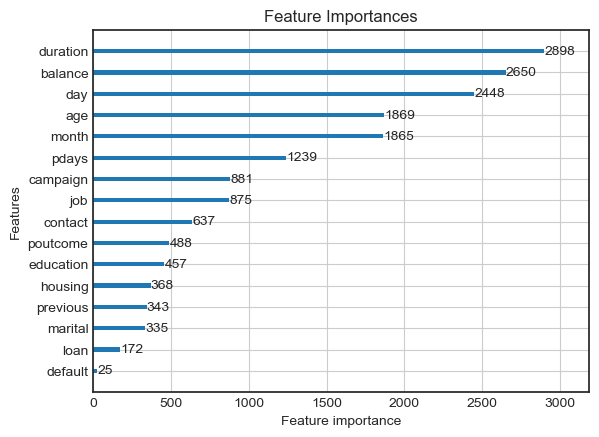

In [8]:
test_data[['ID', 'pred']].to_csv("result.csv", index=False)

plt.figure(figsize=(12,6))
lgb.plot_importance(model, max_num_features=30)
plt.title("Feature Importances")
plt.show()